In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from lcs.agents.macs import MACS, Configuration
from lcs.agents.macs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import gym_maze

## Agent - MACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods14-v0"

NUMBER_OF_EXPLORE_TRIALS = 2000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.025
PROBABILITY_X = 0.3

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ ■ ■ ■ ■ □ ■ ■ □ ■
■ □ ■ ■ ■ □ ■ ■ □ ■ □ ■ □ ■
■ □ ■ ■ ■ A ■ □ ■ ■ ■ □ ■ ■
■ $ ■ ■ ■ □ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ □ □ ■ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


### Training of MACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    prob_x=PROBABILITY_X,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

agent_explore = MACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1min 25s, sys: 471 ms, total: 1min 26s
Wall time: 1min 32s


In [5]:
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

0###10## 	 0 	 1###01## 	 12.578 	 1.000 	 57004.0 	 404 	 empty


#####0## 	 4 	 ######## 	 604.832 	 1.000 	 57609.0 	 716 	 empty


1####### 	 0 	 ######## 	 824.917 	 1.000 	 57620.0 	 1240 	 empty


####1### 	 4 	 ######## 	 583.445 	 1.000 	 57609.0 	 2053 	 empty


#####0## 	 6 	 ######## 	 581.489 	 1.000 	 57495.0 	 845 	 empty


#10#10## 	 5 	 #01#01## 	 902.500 	 1.000 	 57676.0 	 1662 	 empty


10##0### 	 4 	 01##9### 	 950.000 	 1.000 	 57682.0 	 1855 	 empty


01##9### 	 0 	 10##0### 	 899.040 	 0.999 	 57680.0 	 250 	 empty


####9### 	 4 	 ####1### 	 1000.000 	 1.000 	 57682.0 	 1696 	 empty


##0##### 	 0 	 ######## 	 811.661 	 1.000 	 57620.0 	 347 	 empty


#01###01 	 6 	 #10###10 	 630.237 	 1.000 	 57656.0 	 1300 	 empty


1#01###0 	 7 	 0#10###1 	 663.418 	 1.000 	 57657.0 	 1520 	 empty


0####### 	 6 	 ######## 	 751.546 	 1.000 	 57658.0 	 524 	 empty


0#10###1 	 3 	 1#01###0 	 461.698 	 1.000 	 57442.0 	 573 	 empty


#####1## 	 5 	 ######## 	 732.875 	 1.000

### Exploitation of MACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    prob_x=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

agent_exploit = MACS(cfg_exploit, population_explore)
agent_exploit.clean_population()
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 4.63 s, sys: 12.2 ms, total: 4.64 s
Wall time: 4.67 s


### Performance

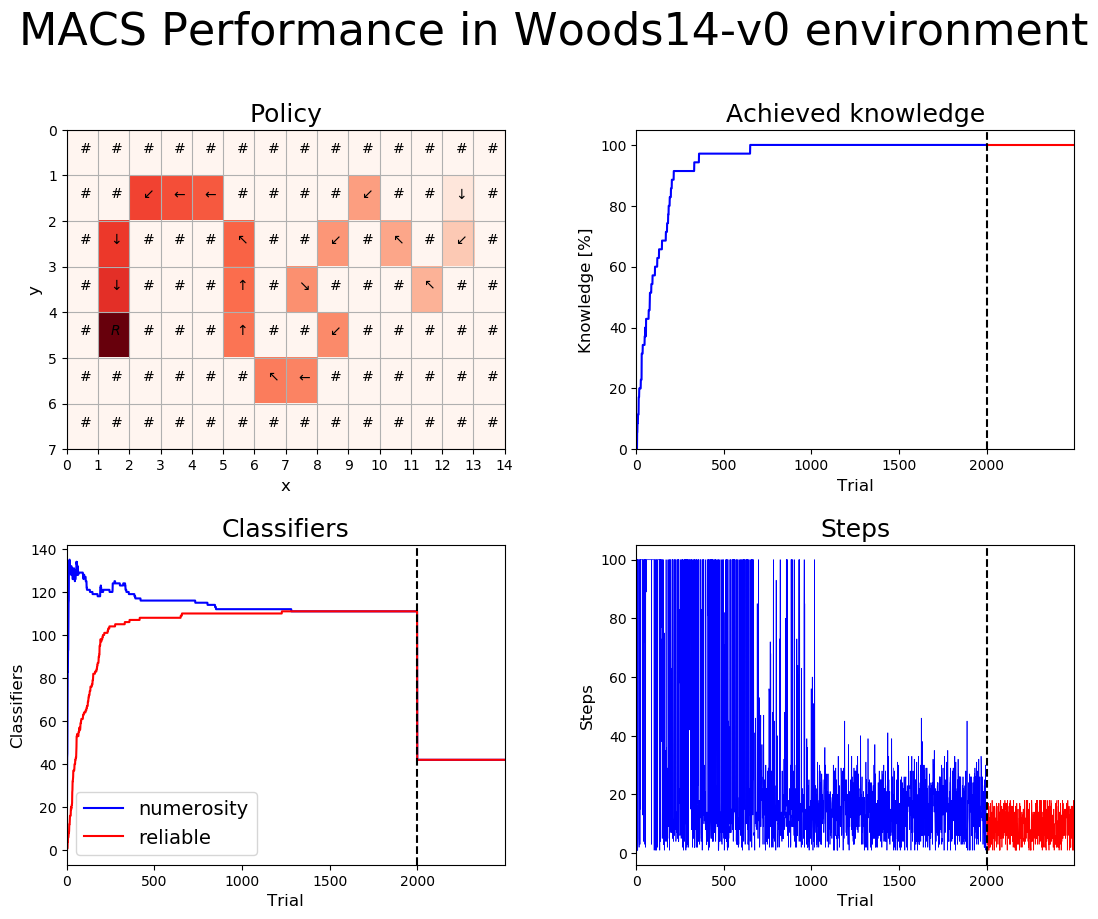

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  28.8415  for a total of  2000  trials in EXPLORATION
Average number of steps to solve the maze is  9.44  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit if cl.does_anticipate_change()]
for cl in population_exploit_to_display:
    print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

####9### 	 4 	 ####1### 	 1000.000 	 1.000 	 1.0 	 1696 	 empty


10##0### 	 4 	 01##9### 	 950.000 	 1.000 	 1.0 	 1855 	 empty


#10#10## 	 5 	 #01#01## 	 902.500 	 1.000 	 1.0 	 1662 	 empty


01##9### 	 0 	 10##0### 	 899.040 	 0.999 	 1.0 	 250 	 empty


##0##10# 	 6 	 #####01# 	 857.375 	 1.000 	 1.0 	 1676 	 empty


#01#01## 	 1 	 #10#10## 	 821.600 	 0.999 	 1.0 	 139 	 empty


##10##0# 	 6 	 ##01#### 	 814.506 	 1.000 	 1.0 	 1630 	 empty


##0##01# 	 2 	 #####10# 	 810.517 	 1.000 	 1.0 	 249 	 empty


###10#10 	 7 	 ###01#01 	 773.781 	 1.000 	 1.0 	 1635 	 empty


0###0##1 	 0 	 1######0 	 735.092 	 1.000 	 1.0 	 2094 	 empty


##01##0# 	 2 	 ##10#### 	 732.069 	 1.000 	 1.0 	 320 	 empty


0##01### 	 0 	 ###10### 	 698.337 	 1.000 	 1.0 	 2279 	 empty


1#01###0 	 7 	 0#10###1 	 663.418 	 1.000 	 1.0 	 1520 	 empty


###01#01 	 3 	 ###10#10 	 645.605 	 1.000 	 1.0 	 446 	 empty


#01###01 	 6 	 #10###10 	 630.237 	 1.000 	 1.0 	 1300 	 empty


#1###010 	 5 	 #0###101 	 598